In [1]:
'''
MIT License

Copyright (c) 2018 Brian McKean

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
'''

'\nMIT License\n\nCopyright (c) 2018 Brian McKean\n\nPermission is hereby granted, free of charge, to any person obtaining a copy\nof this software and associated documentation files (the "Software"), to deal\nin the Software without restriction, including without limitation the rights\nto use, copy, modify, merge, publish, distribute, sublicense, and/or sell\ncopies of the Software, and to permit persons to whom the Software is\nfurnished to do so, subject to the following conditions:\n\nThe above copyright notice and this permission notice shall be included in all\ncopies or substantial portions of the Software.\n\nTHE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR\nIMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,\nFITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE\nAUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER\nLIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM

In [2]:
import pymongo
import pandas as pd
import numpy as np

from pymongo import MongoClient
from bson.objectid import ObjectId

import datetime

import matplotlib.pyplot as plt

from collections import defaultdict


%matplotlib inline
import json
plt.style.use('ggplot')
import seaborn as sns
from math import log10, floor
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer



from sklearn.cluster import KMeans, MiniBatchKMeans
from IPython.display import Image
from IPython.core.display import HTML

import matplotlib.pyplot as plt
import urllib.request

In [3]:
## Connect to local DB

client = MongoClient('localhost', 27017)
print ("Setup db access")
#
# Get collections from mongodb
#

db = client.test

Setup db access


In [4]:
# Find all qual_id's
qual_ids =  db.anon_student_task_responses.distinct('qual_id')




In [5]:
# print (len(qual_ids), qual_ids)

In [6]:
# Get count of qual_id with failures
qual_id_counts =  db.anon_student_task_responses.aggregate(
  [{           
    '$group': {
      '_id': {
        'qual_id': '$qual_id'
      },
      'count': {
        '$sum': 1
      }
    }
    
  }
   ]
)

In [7]:
 qual_id_counts = list(qual_id_counts)

In [8]:
qual_count_df = pd.DataFrame(qual_id_counts)

In [9]:
# print (qual_id_counts)

In [10]:
# print (qual_count_df)

In [11]:
qual_count_df = qual_count_df.sort_values(by='count', ascending=False)

In [12]:
qual_count_df.reset_index(drop=True,inplace=True)
# print (qual_count_df)

In [13]:
qual_id_fail_counts =  db.anon_student_task_responses.aggregate(
  [{           
    '$group': {
      '_id': {
        'qual_id': '$qual_id',
        'correct': 'False'             
      },
      'count': {
        '$sum': 1
      }
    }
    
  }
   ]
)

In [14]:
qual_id_fail_counts = list(qual_id_fail_counts)

In [15]:
qual_fail_count_df = pd.DataFrame(qual_id_fail_counts)

In [16]:
qual_fail_count_df.sort_values(by='count', inplace=True, ascending=False)

In [17]:
# qual_fail_count_df 

In [18]:
## Functions for turning dictionary into document

def make_string_from_list(key, elem_list):
    # Append key to each item in list
    ans = ''
    for elem in elem_list:
        ans += key + '_' + elem 
        
    
        
    

def make_string(elem, key=None, top=True):
    ans = ''
    if not elem:
        return ans
    if top:
        top = False
        top_keys = []
        for idx in range(len(elem.keys())):
            top_keys.append(True)
            
    for idx, key in enumerate(elem.keys()):
        if top_keys[idx]:
            top = True
            top_keys[idx] = False
            ans += ' '
        else:
            top = False
        #print ('ans = ', ans)
        #print (type(elem[key]))
        if type(elem[key]) is str or\
                type(elem[key]) is int:
            #print ('add value', elem[key])
            value = str(elem[key])
            #ans += key + '_' + value + ' ' + value + ' '
            ans += key + '_' + value + ' '
        elif type(elem[key]) is list:
            #print ('add list', elem[key])
            temp_elem = dict()
            for item in elem[key]:
                temp_elem[key] = item
                ans += make_string(temp_elem, top) 
        elif type(elem[key]) is dict:
            #print ('add dict', elem[key])
            for item_key in elem[key].keys():
                temp_elem = dict()
                temp_elem[item_key] = elem[key][item_key]
                ans += key + '_' + make_string(temp_elem, top)
        elif type(elem[key]) is float:
            #print ('add dict', elem[key])
            sig = 2
            value = elem[key]
            value = round(value, sig-int(
            floor(log10(abs(value))))-1)
            value = str(value)
            #ans += key + '_' + value + ' ' + value + ' '
            ans += key + '_' + value + ' '
        # ans += ' ' + key + ' '
        #print ('not handled', elem[key])
     
        
    return ans

In [19]:
def make_doc_data_set(prob_set):
    df3 = pd.DataFrame(list(prob_set))
    df3['response_doc'] = df3['response'].map(make_string)
    df3['response_doc'] = df3['response_doc'].map(lambda x: x + ' ')
    df3['response_doc'] = df3['response_doc'].map(lambda x: x.replace('/','_'))
    df3['response_doc'] = df3['response_doc'] + ' ' + df3['txt'] 
    df3['response_doc'] = df3['response_doc'].map(lambda x: x + ' ')
    df3['response_doc'] = df3['response_doc'].map(lambda x: x.replace("\n", ""))
    df3['response_doc'] = df3['response_doc'].map(lambda x: x.replace("?", " "))
    return df3
    


In [20]:


def make_k_means(data_samples, n_features=200, n_topic=30, n_top_words=10, clusters=10):
    n_samples = len(data_samples)
    print("Extracting tf-idf features ...")
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                       max_features=n_features,
                                       stop_words='english')
    t0 = time()
    tfidf = tfidf_vectorizer.fit_transform(data_samples)
    print("done in %0.3fs." % (time() - t0))
    
    # Number of clusters
    true_k = clusters
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                             init_size=1000, batch_size=1000, random_state=42)
    print("Clustering with %s" % km)
    t0 = time()
    km.fit(tfidf)
    print("done in %0.3fs" % (time() - t0))
    return km


In [21]:
top_ten_qual_id = qual_count_df[:10]

In [22]:
this_qid = top_ten_qual_id.iloc[0]['_id']['qual_id']

In [23]:
top_ten_qual_id

_id  count
0  {'qual_id': 'xSDXuo9OEH.bonus.OG_XxtbnEa'}  22752
1  {'qual_id': 'YN4n4X5GRF.bonus.Q5XY-9tBFu'}  19100
2  {'qual_id': '9wRCzK1G7F.partb.12d_Yq8M01'}  18911
3  {'qual_id': 'TJxldqZMXd.partb.gqJqOrIhu_'}  18390
4  {'qual_id': 'TJxldqZMXd.partb.9L_iTwGd5z'}  18197
5  {'qual_id': 'TJxldqZMXd.partb.W2tLvQTbkI'}  17800
6  {'qual_id': '9wRCzK1G7F.partb.SHkv5F_Yzi'}  17466
7  {'qual_id': 'TJxldqZMXd.partb.hxS1eqLik1'}  17191
8  {'qual_id': '9wRCzK1G7F.partb.qGGEQyiE_j'}  17007
9  {'qual_id': 'kvig7fcCVc.partb.3y7UMHuR_i'}  16876

In [24]:
df_top_ten = []

Analysis 0 for qual_id xSDXuo9OEH.bonus.OG_XxtbnEa with 22752 samples
Session 0 txt  Model a fraction that is equal to  1/4  of the black circle
by covering it with red  1/12  pieces.
Answer: [object Object]
Extracting tf-idf features ...
done in 1.844s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=1, random_state=42, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 0.239s
qual_id xSDXuo9OEH.bonus.OG_XxtbnEa has these clusters
4    3095
1    2091
3    1538
0    1530
2    1271
5    1231
8    1038
9     938
7     825
6     383
Name: cluster, dtype: int64
Cluster 4
http://woot_math_cub.s3.amazonaws.com/ss/74237/OG_XxtbnEa.1470633418484.png
http://woot_math_cub.s3.amazonaws.com/ss/74332/OG_XxtbnEa.1470390328953.png
http://woot_math_cub.s3.amazonaws.com/ss/74649/OG_XxtbnEa.1470767152263.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/

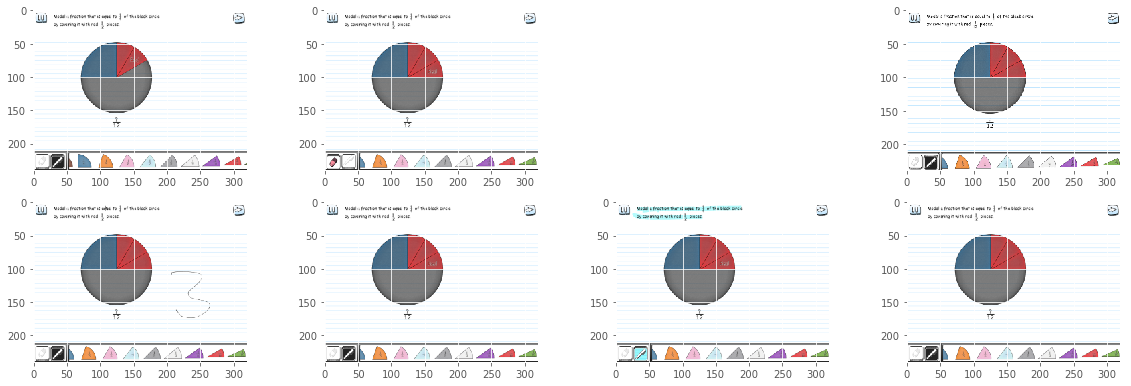

Cluster 1
http://woot_math_cub.s3.amazonaws.com/ss/74332/OG_XxtbnEa.1470390451965.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/74332/OG_XxtbnEa.1470390451965.png
http://woot_math_cub.s3.amazonaws.com/ss/74348/OG_XxtbnEa.1470763790898.png
http://woot_math_cub.s3.amazonaws.com/ss/74230/OG_XxtbnEa.1471389113589.png
http://woot_math_cub.s3.amazonaws.com/ss/74234/OG_XxtbnEa.1471993864774.png
http://woot_math_cub.s3.amazonaws.com/ss/74249/OG_XxtbnEa.1471996076308.png
http://woot_math_cub.s3.amazonaws.com/ss/76154/OG_XxtbnEa.1472237981357.png
http://woot_math_cub.s3.amazonaws.com/ss/74843/OG_XxtbnEa.1472485644965.png
http://woot_math_cub.s3.amazonaws.com/ss/76152/OG_XxtbnEa.1472752852999.png


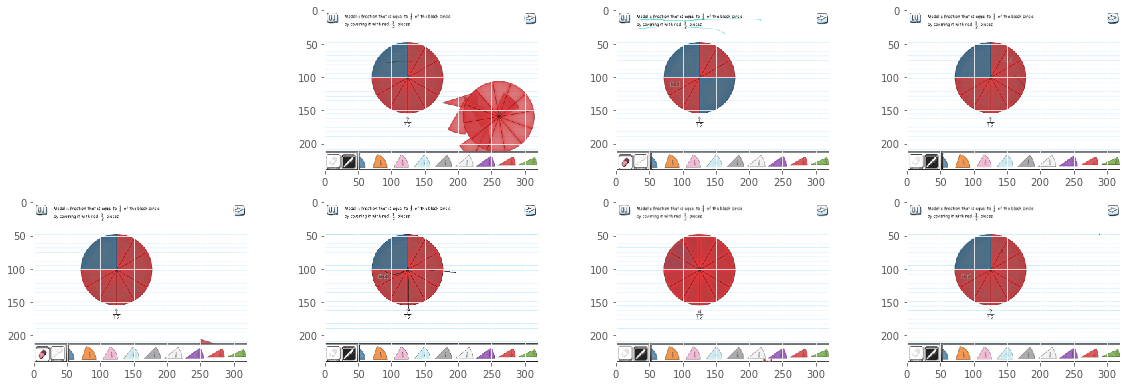

Cluster 3
http://woot_math_cub.s3.amazonaws.com/ss/74354/OG_XxtbnEa.1470407718490.png
http://woot_math_cub.s3.amazonaws.com/ss/74354/OG_XxtbnEa.1470407740359.png
http://woot_math_cub.s3.amazonaws.com/ss/74332/OG_XxtbnEa.1470390426828.png
http://woot_math_cub.s3.amazonaws.com/ss/74348/OG_XxtbnEa.1470763588872.png
http://woot_math_cub.s3.amazonaws.com/ss/74348/OG_XxtbnEa.1470763729943.png
http://woot_math_cub.s3.amazonaws.com/ss/74226/OG_XxtbnEa.1471323917770.png
http://woot_math_cub.s3.amazonaws.com/ss/74843/OG_XxtbnEa.1472485723312.png
http://woot_math_cub.s3.amazonaws.com/ss/74227/OG_XxtbnEa.1472512271279.png


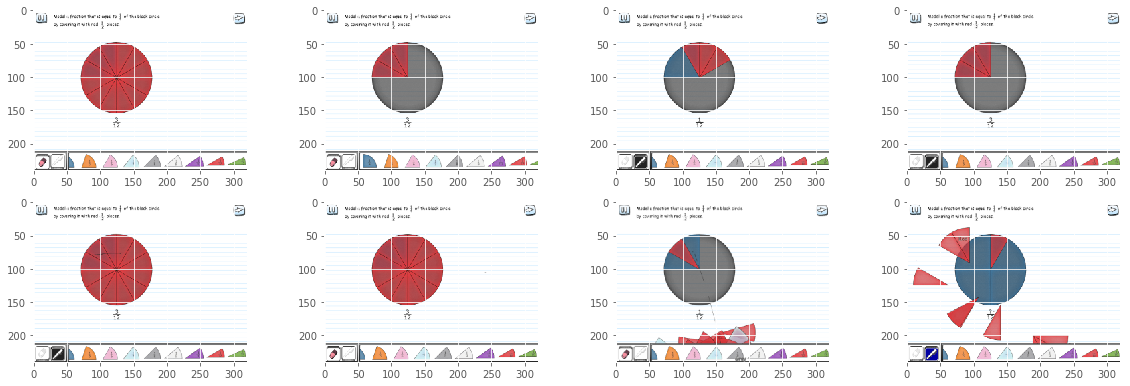

Cluster 0
http://woot_math_cub.s3.amazonaws.com/ss/74226/OG_XxtbnEa.1471323595932.png
http://woot_math_cub.s3.amazonaws.com/ss/74235/OG_XxtbnEa.1471389391489.png
http://woot_math_cub.s3.amazonaws.com/ss/74235/OG_XxtbnEa.1471389397755.png
http://woot_math_cub.s3.amazonaws.com/ss/74701/OG_XxtbnEa.1472653933056.png
http://woot_math_cub.s3.amazonaws.com/ss/76109/OG_XxtbnEa.1472664014370.png
http://woot_math_cub.s3.amazonaws.com/ss/76109/OG_XxtbnEa.1472664082777.png
http://woot_math_cub.s3.amazonaws.com/ss/76147/OG_XxtbnEa.1472752491103.png
http://woot_math_cub.s3.amazonaws.com/ss/77571/OG_XxtbnEa.1472753115057.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77571/OG_XxtbnEa.1472753115057.png


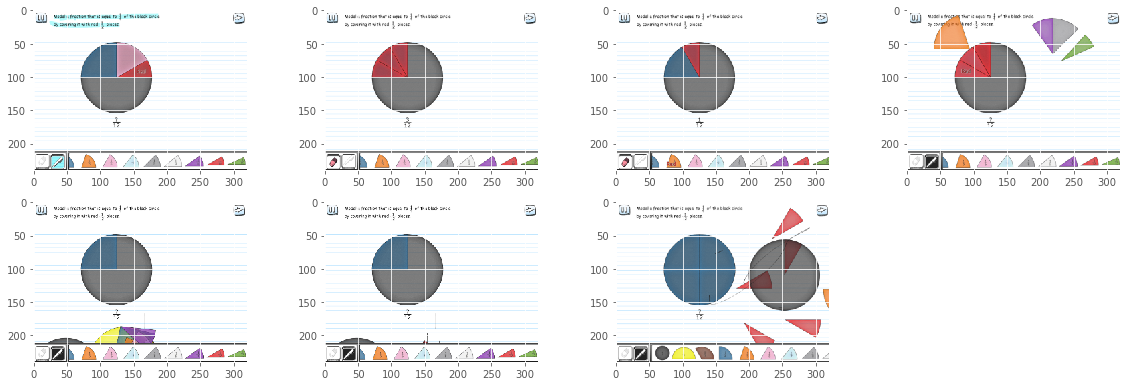

Analysis 1 for qual_id YN4n4X5GRF.bonus.Q5XY-9tBFu with 19100 samples
Session 0 txt  Model a fraction that is equal to 1/2 using the one twelfth red pieces.
Answer: [object Object]
Extracting tf-idf features ...
done in 0.985s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=1, random_state=42, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 0.064s
qual_id YN4n4X5GRF.bonus.Q5XY-9tBFu has these clusters
6    991
2    830
7    672
9    634
8    579
3    555
4    303
1    250
5    177
0     76
Name: cluster, dtype: int64
Cluster 6
http://woot_math_cub.s3.amazonaws.com/ss/74237/Q5XY-9tBFu.1470633048978.png
http://woot_math_cub.s3.amazonaws.com/ss/74232/Q5XY-9tBFu.1471302863019.png
http://woot_math_cub.s3.amazonaws.com/ss/74239/Q5XY-9tBFu.1471821851136.png
http://woot_math_cub.s3.amazonaws.com/ss/77773/Q5XY-9tBFu.1472841562947.png
http://woot_math_c

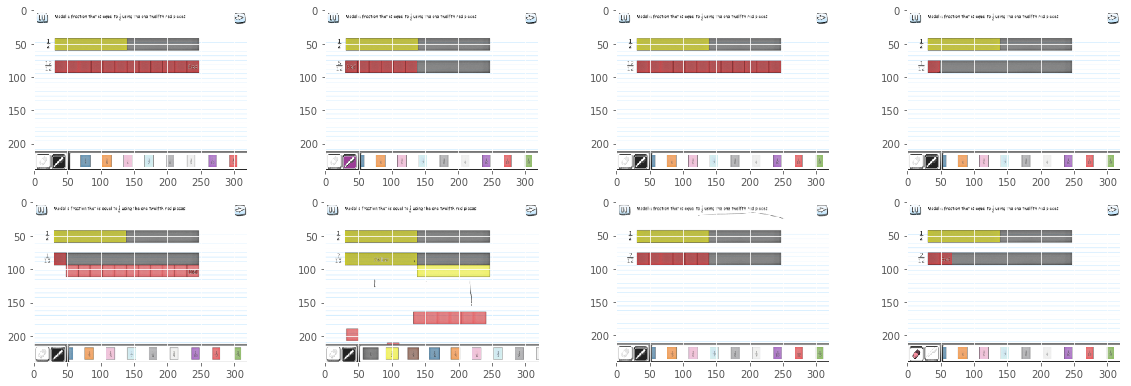

Cluster 2
http://woot_math_cub.s3.amazonaws.com/ss/74237/Q5XY-9tBFu.1470633041978.png
http://woot_math_cub.s3.amazonaws.com/ss/74252/Q5XY-9tBFu.1471389075719.png
http://woot_math_cub.s3.amazonaws.com/ss/74233/Q5XY-9tBFu.1471904641794.png
http://woot_math_cub.s3.amazonaws.com/ss/72827/Q5XY-9tBFu.1472226625330.png
http://woot_math_cub.s3.amazonaws.com/ss/74233/Q5XY-9tBFu.1472290221723.png
http://woot_math_cub.s3.amazonaws.com/ss/74233/Q5XY-9tBFu.1472290239735.png
http://woot_math_cub.s3.amazonaws.com/ss/77773/Q5XY-9tBFu.1472841552013.png
http://woot_math_cub.s3.amazonaws.com/ss/77818/Q5XY-9tBFu.1472833052761.png


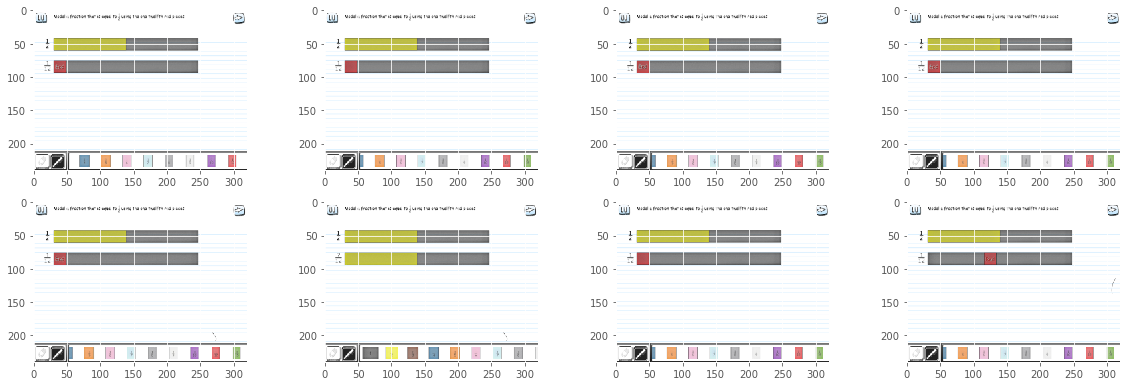

Cluster 7
http://woot_math_cub.s3.amazonaws.com/ss/75505/Q5XY-9tBFu.1472839884141.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/75505/Q5XY-9tBFu.1472839884141.png
http://woot_math_cub.s3.amazonaws.com/ss/77761/Q5XY-9tBFu.1472841275153.png
http://woot_math_cub.s3.amazonaws.com/ss/77772/Q5XY-9tBFu.1472841646907.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77772/Q5XY-9tBFu.1472841646907.png
http://woot_math_cub.s3.amazonaws.com/ss/75571/Q5XY-9tBFu.1472831099805.png
http://woot_math_cub.s3.amazonaws.com/ss/75823/Q5XY-9tBFu.1472845259524.png
http://woot_math_cub.s3.amazonaws.com/ss/77774/Q5XY-9tBFu.1472846584154.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77774/Q5XY-9tBFu.1472846584154.png
http://woot_math_cub.s3.amazonaws.com/ss/76901/Q5XY-9tBFu.1473254301884.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/76901/Q5XY-9tBFu.1473254301884.png
http://woot_math_cub.s3.amazonaws.com/ss/77187/Q5XY-9tBFu.1473257648953.png
 could not rea

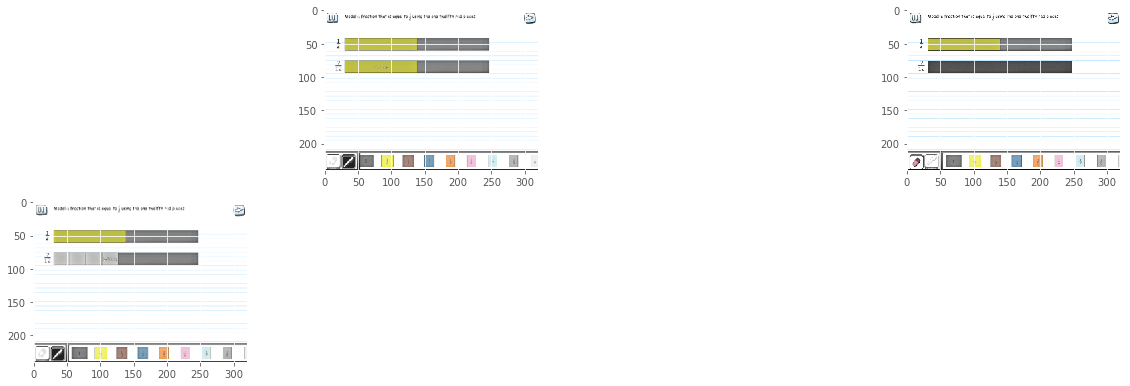

Cluster 9
http://woot_math_cub.s3.amazonaws.com/ss/76831/Q5XY-9tBFu.1486751143006.png
http://woot_math_cub.s3.amazonaws.com/ss/76831/Q5XY-9tBFu.1486751170221.png
http://woot_math_cub.s3.amazonaws.com/ss/104940/Q5XY-9tBFu.1486767427209.png
http://woot_math_cub.s3.amazonaws.com/ss/106265/Q5XY-9tBFu.1486789343502.png
http://woot_math_cub.s3.amazonaws.com/ss/106277/Q5XY-9tBFu.1486999476384.png
http://woot_math_cub.s3.amazonaws.com/ss/106271/Q5XY-9tBFu.1486999518608.png
http://woot_math_cub.s3.amazonaws.com/ss/105223/Q5XY-9tBFu.1487006746452.png
http://woot_math_cub.s3.amazonaws.com/ss/76831/Q5XY-9tBFu.1487007633550.png


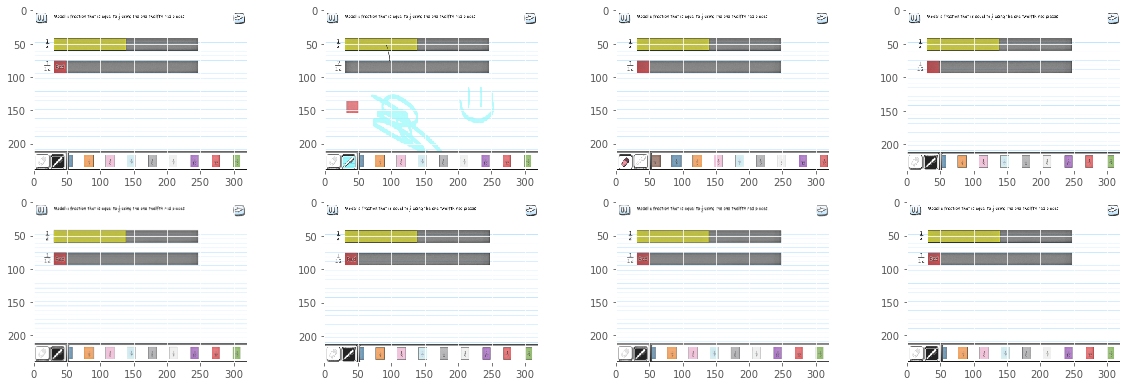

Analysis 2 for qual_id 9wRCzK1G7F.partb.12d_Yq8M01 with 18911 samples
Session 0 txt  The brown is the whole unit. Which of these pieces is one third of the brown piece?
Drag the piece to the answer box.
Answer: 1/9
Extracting tf-idf features ...
done in 0.434s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=1, random_state=42, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 0.040s
qual_id 9wRCzK1G7F.partb.12d_Yq8M01 has these clusters
6    1132
3     796
0     697
4     509
5     467
1     313
2     283
7     233
9     201
8      33
Name: cluster, dtype: int64
Cluster 6
http://woot_math_cub.s3.amazonaws.com/ss/74320/12d_Yq8M01.1470298516194.png
http://woot_math_cub.s3.amazonaws.com/ss/74703/12d_Yq8M01.1472220509900.png
http://woot_math_cub.s3.amazonaws.com/ss/74703/12d_Yq8M01.1472220634506.png
http://woot_math_cub.s3.amazonaws.com/ss/74690/12d

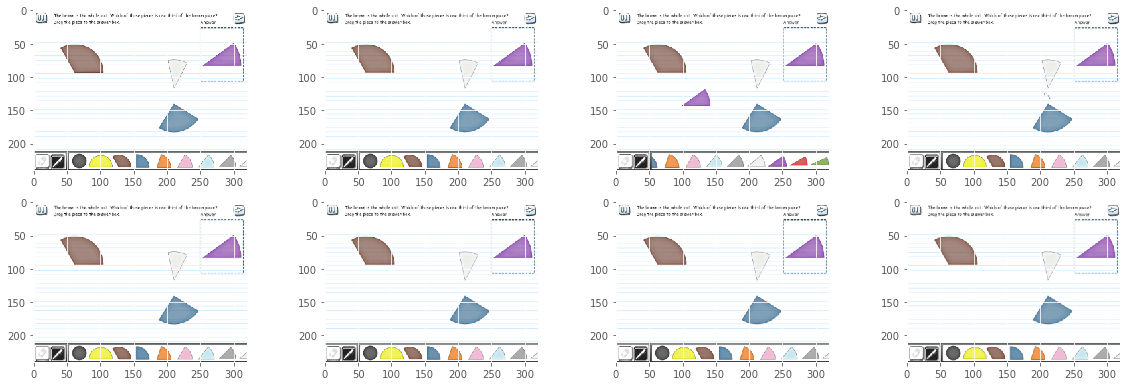

Cluster 3
http://woot_math_cub.s3.amazonaws.com/ss/74249/12d_Yq8M01.1470180407271.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/74249/12d_Yq8M01.1470180407271.png
http://woot_math_cub.s3.amazonaws.com/ss/74247/12d_Yq8M01.1470180650644.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/74247/12d_Yq8M01.1470180650644.png
http://woot_math_cub.s3.amazonaws.com/ss/73678/12d_Yq8M01.1470930189349.png
http://woot_math_cub.s3.amazonaws.com/ss/76147/12d_Yq8M01.1472751519855.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/76147/12d_Yq8M01.1472751519855.png
http://woot_math_cub.s3.amazonaws.com/ss/76114/12d_Yq8M01.1472752407464.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/76114/12d_Yq8M01.1472752407464.png
http://woot_math_cub.s3.amazonaws.com/ss/76127/12d_Yq8M01.1472838210282.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/76127/12d_Yq8M01.1472838210282.png
http://woot_math_cub.s3.amazonaws.com/ss/76891/12d_Yq8M01.1473251630185.pn

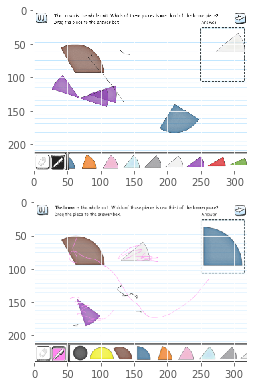

Cluster 0
http://woot_math_cub.s3.amazonaws.com/ss/74320/12d_Yq8M01.1470387482688.png
http://woot_math_cub.s3.amazonaws.com/ss/74917/12d_Yq8M01.1471177003817.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/74917/12d_Yq8M01.1471177003817.png
http://woot_math_cub.s3.amazonaws.com/ss/76155/12d_Yq8M01.1472752176644.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/76155/12d_Yq8M01.1472752176644.png
http://woot_math_cub.s3.amazonaws.com/ss/76139/12d_Yq8M01.1472837483869.png
http://woot_math_cub.s3.amazonaws.com/ss/77156/12d_Yq8M01.1473265044026.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77156/12d_Yq8M01.1473265044026.png
http://woot_math_cub.s3.amazonaws.com/ss/77167/12d_Yq8M01.1473265841114.png
http://woot_math_cub.s3.amazonaws.com/ss/77668/12d_Yq8M01.1473352974511.png
http://woot_math_cub.s3.amazonaws.com/ss/76375/12d_Yq8M01.1473358111200.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/76375/12d_Yq8M01.1473358111200.png


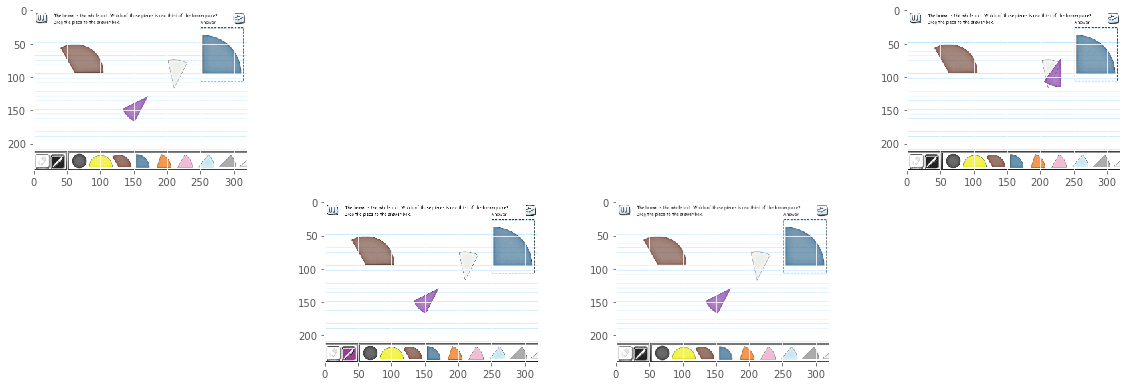

Cluster 4
http://woot_math_cub.s3.amazonaws.com/ss/74332/12d_Yq8M01.1470386952824.png
http://woot_math_cub.s3.amazonaws.com/ss/74328/12d_Yq8M01.1471509194886.png
http://woot_math_cub.s3.amazonaws.com/ss/77651/12d_Yq8M01.1473273816630.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77651/12d_Yq8M01.1473273816630.png
http://woot_math_cub.s3.amazonaws.com/ss/75280/12d_Yq8M01.1473427631877.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/75280/12d_Yq8M01.1473427631877.png
http://woot_math_cub.s3.amazonaws.com/ss/75280/12d_Yq8M01.1473427760409.png
http://woot_math_cub.s3.amazonaws.com/ss/75275/12d_Yq8M01.1473427760352.png
http://woot_math_cub.s3.amazonaws.com/ss/77644/12d_Yq8M01.1473435070809.png
http://woot_math_cub.s3.amazonaws.com/ss/78114/12d_Yq8M01.1473956237528.png


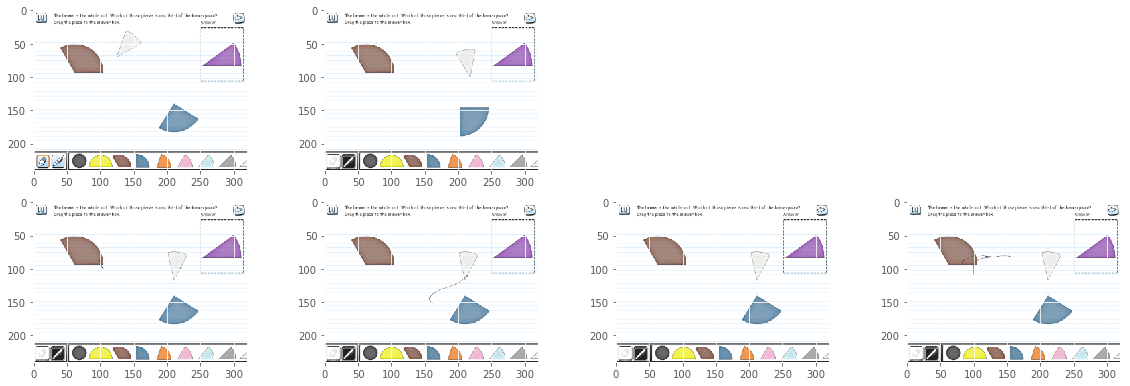

Analysis 3 for qual_id TJxldqZMXd.partb.gqJqOrIhu_ with 18390 samples
Session 0 txt  Drag one sixth pieces to cover all of the  2/3  shown.
Answer: 4
Extracting tf-idf features ...
done in 1.206s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=1, random_state=42, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 0.098s
qual_id TJxldqZMXd.partb.gqJqOrIhu_ has these clusters
6    578
1    515
4    367
5    253
2    245
0    239
8    183
7    165
3    109
9     22
Name: cluster, dtype: int64
Cluster 6
http://woot_math_cub.s3.amazonaws.com/ss/72810/gqJqOrIhu_.1470694031920.png
http://woot_math_cub.s3.amazonaws.com/ss/74235/gqJqOrIhu_.1471907658455.png
http://woot_math_cub.s3.amazonaws.com/ss/74843/gqJqOrIhu_.1472686166061.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/74843/gqJqOrIhu_.1472686166061.png
http://woot_math_cub.s3.amazonaws

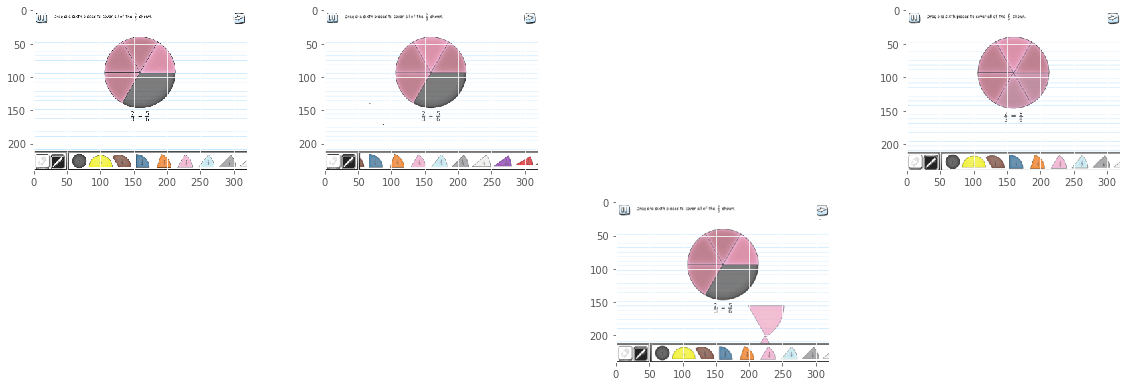

Cluster 1
http://woot_math_cub.s3.amazonaws.com/ss/72538/gqJqOrIhu_.1470184473430.png
http://woot_math_cub.s3.amazonaws.com/ss/76147/gqJqOrIhu_.1472752768059.png
http://woot_math_cub.s3.amazonaws.com/ss/76891/gqJqOrIhu_.1473424863009.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/76891/gqJqOrIhu_.1473424863009.png
http://woot_math_cub.s3.amazonaws.com/ss/77651/gqJqOrIhu_.1473445593906.png
http://woot_math_cub.s3.amazonaws.com/ss/77651/gqJqOrIhu_.1473445585855.png
http://woot_math_cub.s3.amazonaws.com/ss/77132/gqJqOrIhu_.1473709302686.png
http://woot_math_cub.s3.amazonaws.com/ss/76904/gqJqOrIhu_.1473773137573.png
http://woot_math_cub.s3.amazonaws.com/ss/77157/gqJqOrIhu_.1473861201047.png


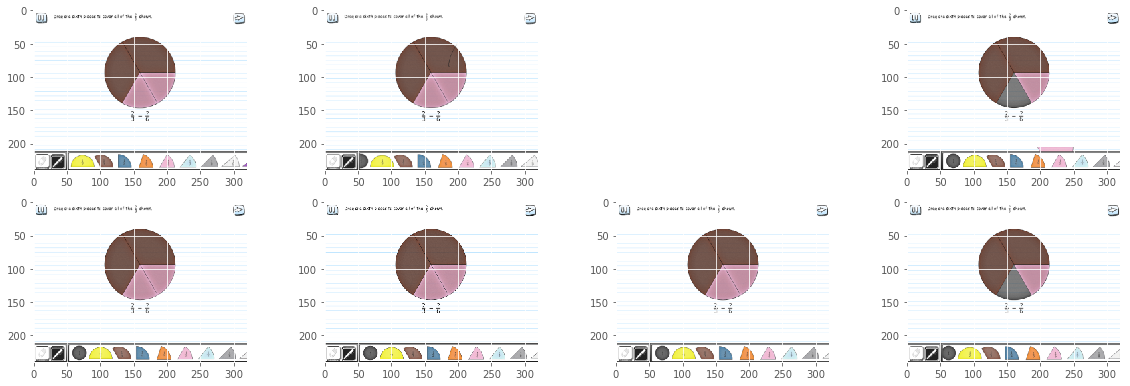

Cluster 4
http://woot_math_cub.s3.amazonaws.com/ss/74252/gqJqOrIhu_.1471820829138.png
http://woot_math_cub.s3.amazonaws.com/ss/77682/gqJqOrIhu_.1473353013532.png
http://woot_math_cub.s3.amazonaws.com/ss/76902/gqJqOrIhu_.1473361744147.png
http://woot_math_cub.s3.amazonaws.com/ss/76891/gqJqOrIhu_.1473424822522.png
http://woot_math_cub.s3.amazonaws.com/ss/77226/gqJqOrIhu_.1473626458885.png
http://woot_math_cub.s3.amazonaws.com/ss/77127/gqJqOrIhu_.1473709120136.png
http://woot_math_cub.s3.amazonaws.com/ss/77157/gqJqOrIhu_.1473861186681.png
http://woot_math_cub.s3.amazonaws.com/ss/82943/gqJqOrIhu_.1473883571451.png


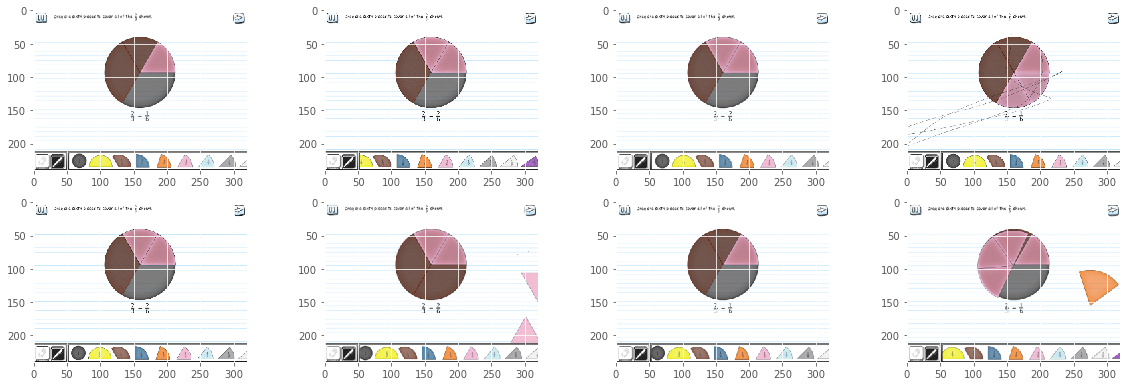

Cluster 5
http://woot_math_cub.s3.amazonaws.com/ss/74235/gqJqOrIhu_.1471907377285.png
http://woot_math_cub.s3.amazonaws.com/ss/77161/gqJqOrIhu_.1473265999101.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77161/gqJqOrIhu_.1473265999101.png
http://woot_math_cub.s3.amazonaws.com/ss/77102/gqJqOrIhu_.1473695337669.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77102/gqJqOrIhu_.1473695337669.png
http://woot_math_cub.s3.amazonaws.com/ss/77102/gqJqOrIhu_.1473869616032.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77102/gqJqOrIhu_.1473869616032.png
http://woot_math_cub.s3.amazonaws.com/ss/77554/gqJqOrIhu_.1473875446446.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77554/gqJqOrIhu_.1473875446446.png
http://woot_math_cub.s3.amazonaws.com/ss/82930/gqJqOrIhu_.1473873213166.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/82930/gqJqOrIhu_.1473873213166.png
http://woot_math_cub.s3.amazonaws.com/ss/77094/gqJqOrIhu_.1474466217898.pn

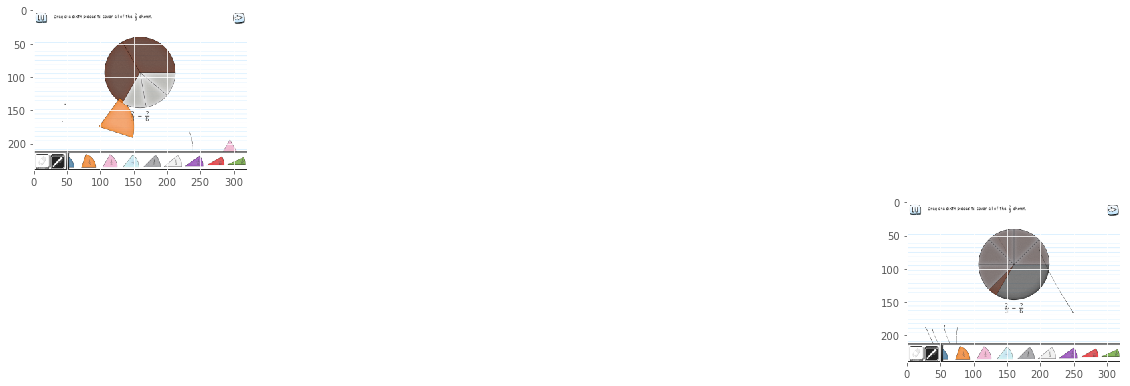

Analysis 4 for qual_id TJxldqZMXd.partb.9L_iTwGd5z with 18197 samples
Session 0 txt  Drag one eighth pieces to cover all of the  3/4  shown.
Answer: 6
Extracting tf-idf features ...
done in 0.387s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=1, random_state=42, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 0.114s
qual_id TJxldqZMXd.partb.9L_iTwGd5z has these clusters
0    1094
4     409
2     317
1     206
3     144
5     122
8      48
6      34
9      28
7      21
Name: cluster, dtype: int64
Cluster 0
http://woot_math_cub.s3.amazonaws.com/ss/74588/9L_iTwGd5z.1470626243705.png
http://woot_math_cub.s3.amazonaws.com/ss/74703/9L_iTwGd5z.1472221390322.png
http://woot_math_cub.s3.amazonaws.com/ss/74703/9L_iTwGd5z.1472221398201.png
http://woot_math_cub.s3.amazonaws.com/ss/76109/9L_iTwGd5z.1472664448607.png
http://woot_math_cub.s3.amazonaws.com/

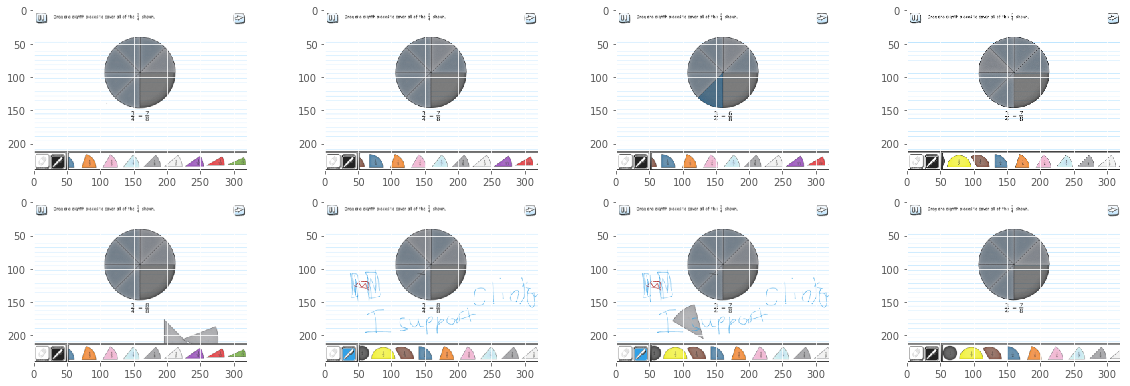

Cluster 4
http://woot_math_cub.s3.amazonaws.com/ss/74328/9L_iTwGd5z.1471510224742.png
http://woot_math_cub.s3.amazonaws.com/ss/74843/9L_iTwGd5z.1472686302551.png
http://woot_math_cub.s3.amazonaws.com/ss/77573/9L_iTwGd5z.1472752739965.png
http://woot_math_cub.s3.amazonaws.com/ss/77682/9L_iTwGd5z.1473352885416.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77682/9L_iTwGd5z.1473352885416.png
http://woot_math_cub.s3.amazonaws.com/ss/77682/9L_iTwGd5z.1473353178343.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77682/9L_iTwGd5z.1473353178343.png
http://woot_math_cub.s3.amazonaws.com/ss/77682/9L_iTwGd5z.1473353230425.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77682/9L_iTwGd5z.1473353230425.png
http://woot_math_cub.s3.amazonaws.com/ss/77104/9L_iTwGd5z.1473869098407.png
http://woot_math_cub.s3.amazonaws.com/ss/76344/9L_iTwGd5z.1473973921074.png


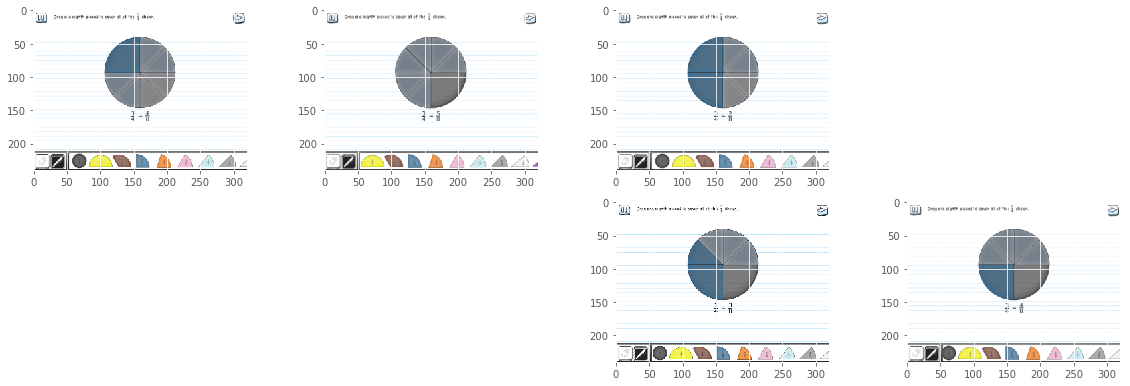

Cluster 2
http://woot_math_cub.s3.amazonaws.com/ss/72538/9L_iTwGd5z.1470184484331.png
http://woot_math_cub.s3.amazonaws.com/ss/74349/9L_iTwGd5z.1470422800865.png
http://woot_math_cub.s3.amazonaws.com/ss/74349/9L_iTwGd5z.1470422814079.png
http://woot_math_cub.s3.amazonaws.com/ss/74315/9L_iTwGd5z.1470547443116.png
http://woot_math_cub.s3.amazonaws.com/ss/74315/9L_iTwGd5z.1470547346968.png
http://woot_math_cub.s3.amazonaws.com/ss/74237/9L_iTwGd5z.1470636408876.png
http://woot_math_cub.s3.amazonaws.com/ss/71257/9L_iTwGd5z.1471104810412.png
http://woot_math_cub.s3.amazonaws.com/ss/77651/9L_iTwGd5z.1473445608571.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77651/9L_iTwGd5z.1473445608571.png


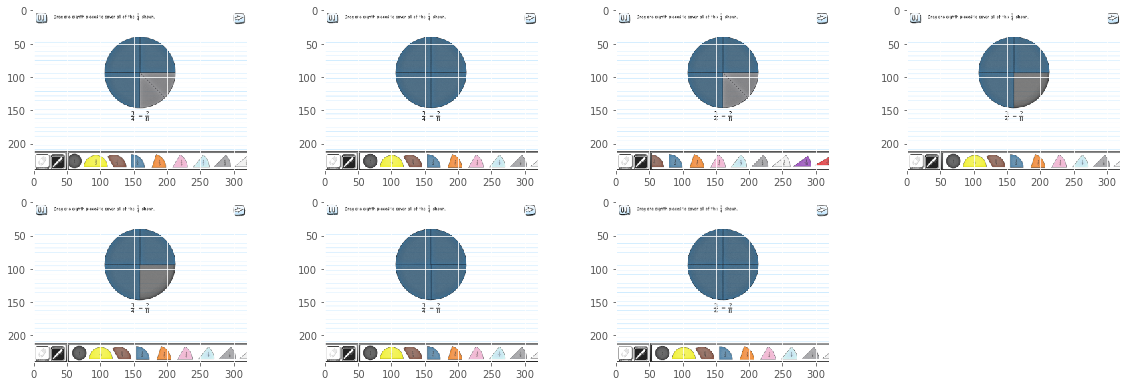

Cluster 1
http://woot_math_cub.s3.amazonaws.com/ss/77161/9L_iTwGd5z.1473266000688.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77161/9L_iTwGd5z.1473266000688.png
http://woot_math_cub.s3.amazonaws.com/ss/77102/9L_iTwGd5z.1473695339769.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77102/9L_iTwGd5z.1473695339769.png
http://woot_math_cub.s3.amazonaws.com/ss/77102/9L_iTwGd5z.1473869617798.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77102/9L_iTwGd5z.1473869617798.png
http://woot_math_cub.s3.amazonaws.com/ss/77554/9L_iTwGd5z.1473875455795.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77554/9L_iTwGd5z.1473875455795.png
http://woot_math_cub.s3.amazonaws.com/ss/82930/9L_iTwGd5z.1473873216999.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/82930/9L_iTwGd5z.1473873216999.png
http://woot_math_cub.s3.amazonaws.com/ss/77094/9L_iTwGd5z.1474466222390.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77094/9L_iTwGd5z.

Analysis 5 for qual_id TJxldqZMXd.partb.W2tLvQTbkI with 17800 samples
Session 0 txt  Drag one half pieces to cover all of the  2/4  shown.
Answer: 1
Extracting tf-idf features ...
done in 0.302s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=1, random_state=42, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 0.081s
qual_id TJxldqZMXd.partb.W2tLvQTbkI has these clusters
3    707
1    347
7    341
2    254
8    194
6    130
4    127
0     83
9     62
5     47
Name: cluster, dtype: int64
Cluster 3
http://woot_math_cub.s3.amazonaws.com/ss/74653/W2tLvQTbkI.1470753690866.png
http://woot_math_cub.s3.amazonaws.com/ss/74649/W2tLvQTbkI.1470767251181.png
http://woot_math_cub.s3.amazonaws.com/ss/74234/W2tLvQTbkI.1471994653368.png
http://woot_math_cub.s3.amazonaws.com/ss/74227/W2tLvQTbkI.1472598444897.png
http://woot_math_cub.s3.amazonaws.com/ss/74704/W2t

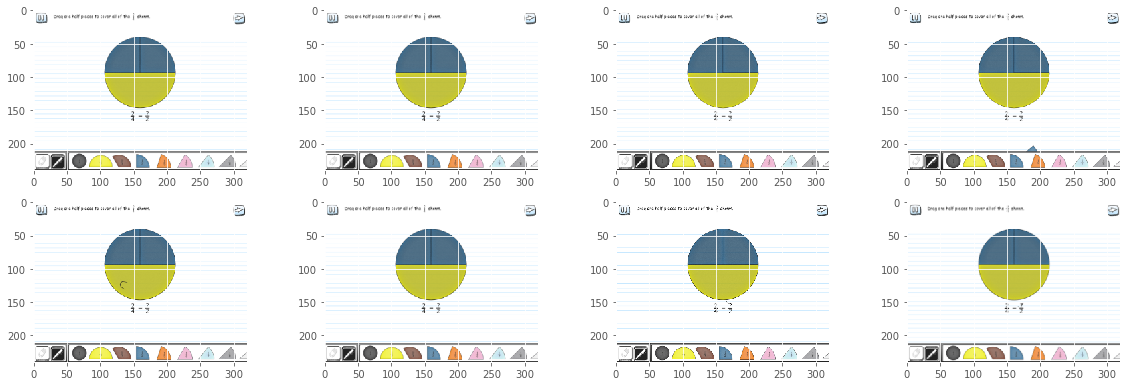

Cluster 1
http://woot_math_cub.s3.amazonaws.com/ss/74315/W2tLvQTbkI.1470547382715.png
http://woot_math_cub.s3.amazonaws.com/ss/74228/W2tLvQTbkI.1471331958196.png
http://woot_math_cub.s3.amazonaws.com/ss/74228/W2tLvQTbkI.1471331966782.png
http://woot_math_cub.s3.amazonaws.com/ss/74228/W2tLvQTbkI.1471333083709.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/74228/W2tLvQTbkI.1471333083709.png
http://woot_math_cub.s3.amazonaws.com/ss/76147/W2tLvQTbkI.1472752754789.png
http://woot_math_cub.s3.amazonaws.com/ss/77651/W2tLvQTbkI.1473445572129.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77651/W2tLvQTbkI.1473445572129.png
http://woot_math_cub.s3.amazonaws.com/ss/77594/W2tLvQTbkI.1473701696895.png
http://woot_math_cub.s3.amazonaws.com/ss/75276/W2tLvQTbkI.1473945688765.png


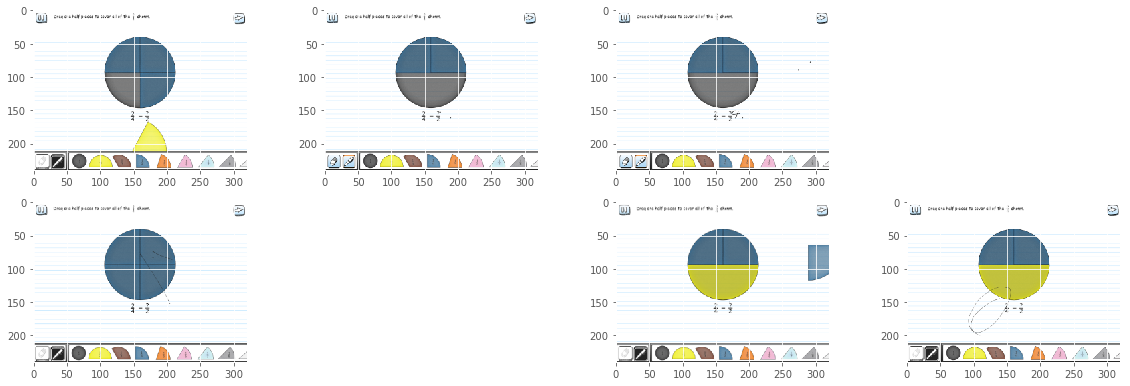

Cluster 7
http://woot_math_cub.s3.amazonaws.com/ss/72538/W2tLvQTbkI.1470183993935.png
http://woot_math_cub.s3.amazonaws.com/ss/74237/W2tLvQTbkI.1470636362319.png
http://woot_math_cub.s3.amazonaws.com/ss/74654/W2tLvQTbkI.1470754323510.png
http://woot_math_cub.s3.amazonaws.com/ss/74244/W2tLvQTbkI.1471993862752.png
http://woot_math_cub.s3.amazonaws.com/ss/76879/W2tLvQTbkI.1473340898398.png
http://woot_math_cub.s3.amazonaws.com/ss/77651/W2tLvQTbkI.1473445560319.png
http://woot_math_cub.s3.amazonaws.com/ss/77102/W2tLvQTbkI.1473695335003.png
http://woot_math_cub.s3.amazonaws.com/ss/76360/W2tLvQTbkI.1473894681024.png


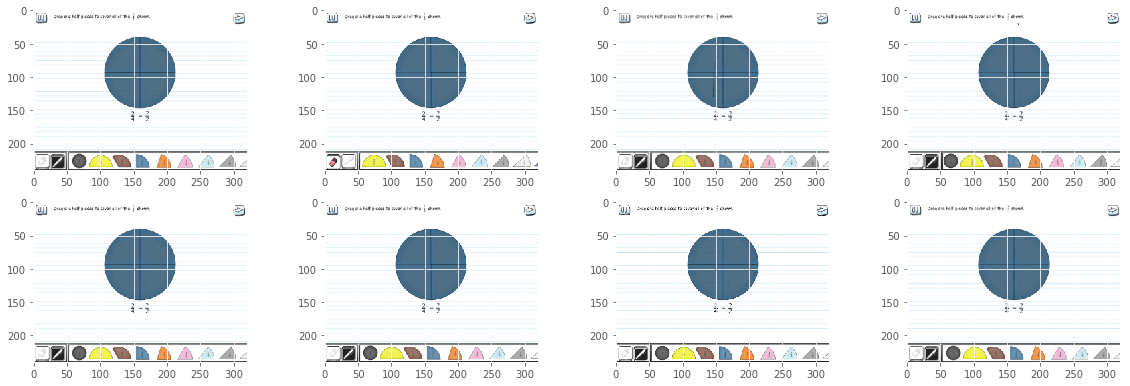

Cluster 2
http://woot_math_cub.s3.amazonaws.com/ss/74252/W2tLvQTbkI.1471820792006.png
http://woot_math_cub.s3.amazonaws.com/ss/77161/W2tLvQTbkI.1473265996271.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77161/W2tLvQTbkI.1473265996271.png
http://woot_math_cub.s3.amazonaws.com/ss/77102/W2tLvQTbkI.1473869614140.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77102/W2tLvQTbkI.1473869614140.png
http://woot_math_cub.s3.amazonaws.com/ss/77554/W2tLvQTbkI.1473875443245.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77554/W2tLvQTbkI.1473875443245.png
http://woot_math_cub.s3.amazonaws.com/ss/82930/W2tLvQTbkI.1473873208432.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/82930/W2tLvQTbkI.1473873208432.png
http://woot_math_cub.s3.amazonaws.com/ss/78973/W2tLvQTbkI.1474391500777.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/78973/W2tLvQTbkI.1474391500777.png
http://woot_math_cub.s3.amazonaws.com/ss/77094/W2tLvQTbkI.1474466216168.pn

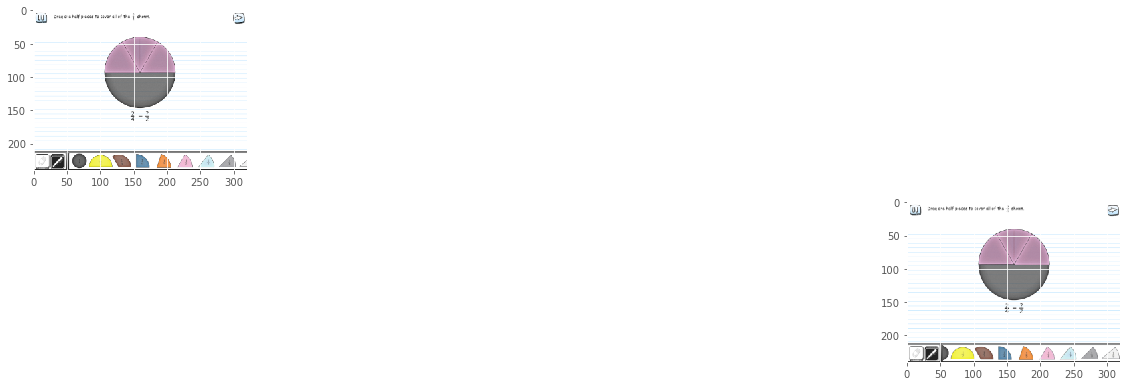

Analysis 6 for qual_id 9wRCzK1G7F.partb.SHkv5F_Yzi with 17466 samples
Session 0 txt  The orange is the whole unit. Which of these pieces is one half of the orange piece?
Drag the piece to the answer box.
Answer: 1/10
Extracting tf-idf features ...
done in 8.772s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=1, random_state=42, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 0.673s
qual_id 9wRCzK1G7F.partb.SHkv5F_Yzi has these clusters
1    2314
2    1278
7     808
3     440
9     231
4     194
8     171
5     125
6      32
0       9
Name: cluster, dtype: int64
Cluster 1
http://woot_math_cub.s3.amazonaws.com/ss/74327/SHkv5F_Yzi.1470298533021.png
http://woot_math_cub.s3.amazonaws.com/ss/74151/SHkv5F_Yzi.1470250546472.png
http://woot_math_cub.s3.amazonaws.com/ss/74151/SHkv5F_Yzi.1470250550261.png
http://woot_math_cub.s3.amazonaws.com/ss/74329/S

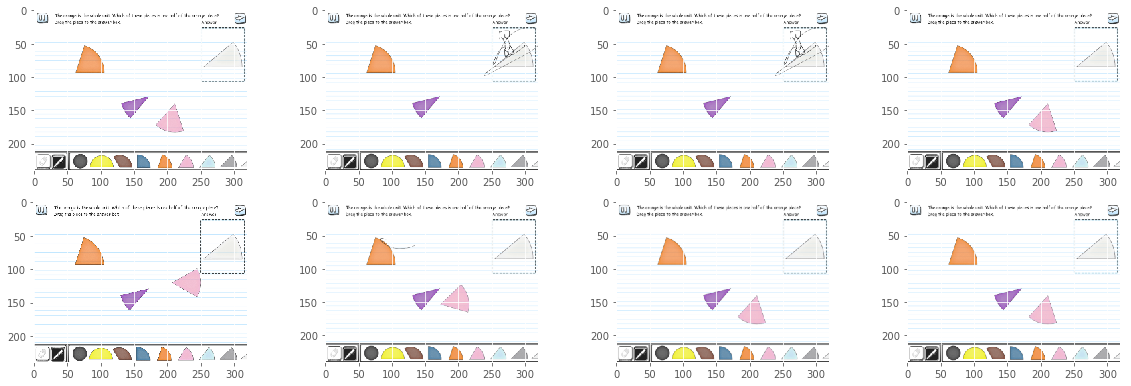

Cluster 2
http://woot_math_cub.s3.amazonaws.com/ss/74244/SHkv5F_Yzi.1470180252918.png
http://woot_math_cub.s3.amazonaws.com/ss/74245/SHkv5F_Yzi.1470180573765.png
http://woot_math_cub.s3.amazonaws.com/ss/73678/SHkv5F_Yzi.1470929967046.png
http://woot_math_cub.s3.amazonaws.com/ss/74709/SHkv5F_Yzi.1471453583232.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/74709/SHkv5F_Yzi.1471453583232.png
http://woot_math_cub.s3.amazonaws.com/ss/76311/SHkv5F_Yzi.1472504163240.png
http://woot_math_cub.s3.amazonaws.com/ss/77574/SHkv5F_Yzi.1472751671457.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77574/SHkv5F_Yzi.1472751671457.png
http://woot_math_cub.s3.amazonaws.com/ss/76156/SHkv5F_Yzi.1472752443587.png
http://woot_math_cub.s3.amazonaws.com/ss/77574/SHkv5F_Yzi.1472752879241.png


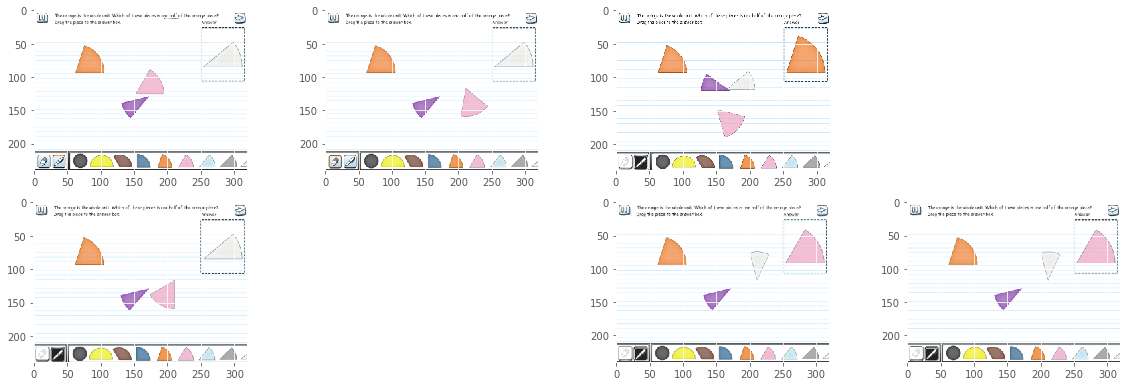

Cluster 7
http://woot_math_cub.s3.amazonaws.com/ss/74226/SHkv5F_Yzi.1470180294622.png
http://woot_math_cub.s3.amazonaws.com/ss/74332/SHkv5F_Yzi.1470386901454.png
http://woot_math_cub.s3.amazonaws.com/ss/74238/SHkv5F_Yzi.1471216543977.png
http://woot_math_cub.s3.amazonaws.com/ss/74281/SHkv5F_Yzi.1471478012086.png
http://woot_math_cub.s3.amazonaws.com/ss/77647/SHkv5F_Yzi.1473273968172.png
http://woot_math_cub.s3.amazonaws.com/ss/75280/SHkv5F_Yzi.1473427689284.png
http://woot_math_cub.s3.amazonaws.com/ss/75867/SHkv5F_Yzi.1473430382224.png
http://woot_math_cub.s3.amazonaws.com/ss/77640/SHkv5F_Yzi.1473432914086.png


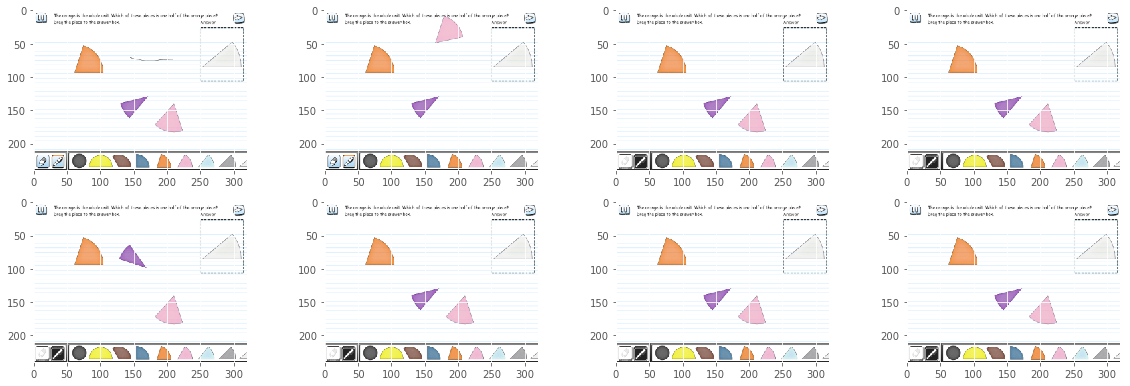

Cluster 3
http://woot_math_cub.s3.amazonaws.com/ss/74320/SHkv5F_Yzi.1470298230909.png
http://woot_math_cub.s3.amazonaws.com/ss/74685/SHkv5F_Yzi.1472869085803.png
http://woot_math_cub.s3.amazonaws.com/ss/77158/SHkv5F_Yzi.1473257563783.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77158/SHkv5F_Yzi.1473257563783.png
http://woot_math_cub.s3.amazonaws.com/ss/76375/SHkv5F_Yzi.1473358494934.png
http://woot_math_cub.s3.amazonaws.com/ss/76894/SHkv5F_Yzi.1473423999340.png
http://woot_math_cub.s3.amazonaws.com/ss/76336/SHkv5F_Yzi.1473424078984.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/76336/SHkv5F_Yzi.1473424078984.png
http://woot_math_cub.s3.amazonaws.com/ss/76344/SHkv5F_Yzi.1473687652877.png
http://woot_math_cub.s3.amazonaws.com/ss/76877/SHkv5F_Yzi.1473686811655.png


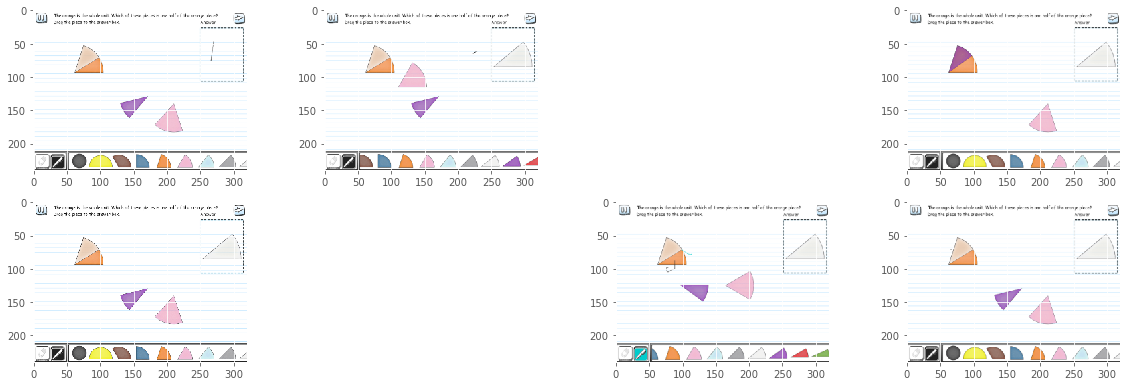

Analysis 7 for qual_id TJxldqZMXd.partb.hxS1eqLik1 with 17191 samples
Session 0 txt  Drag one half pieces to cover all of the  4/8  shown.
Answer: 1
Extracting tf-idf features ...
done in 0.315s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=1, random_state=42, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 0.198s
qual_id TJxldqZMXd.partb.hxS1eqLik1 has these clusters
3    265
1    240
5    150
6    121
2     72
0     72
8     46
9     40
4     30
7     22
Name: cluster, dtype: int64
Cluster 3
http://woot_math_cub.s3.amazonaws.com/ss/74237/hxS1eqLik1.1470636297167.png
http://woot_math_cub.s3.amazonaws.com/ss/74654/hxS1eqLik1.1470754406444.png
http://woot_math_cub.s3.amazonaws.com/ss/74224/hxS1eqLik1.1471907215068.png
http://woot_math_cub.s3.amazonaws.com/ss/76901/hxS1eqLik1.1473255321109.png
http://woot_math_cub.s3.amazonaws.com/ss/76901/hxS

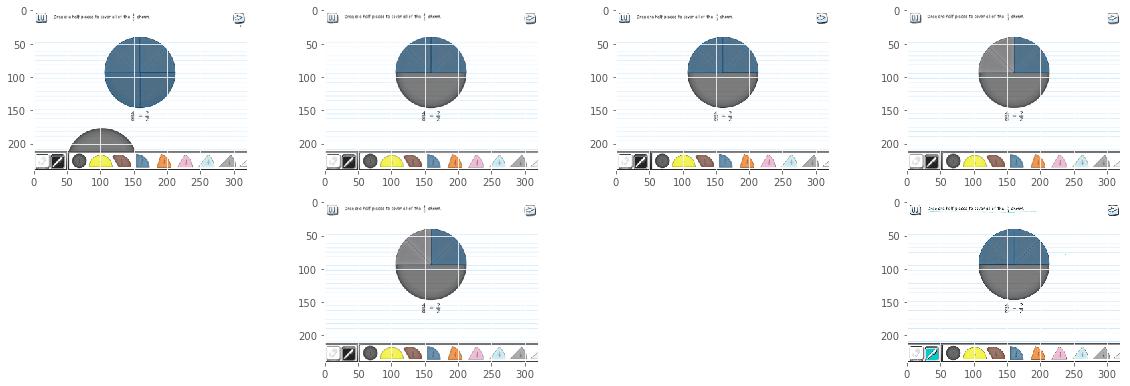

Cluster 1
http://woot_math_cub.s3.amazonaws.com/ss/77161/hxS1eqLik1.1473266002298.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77161/hxS1eqLik1.1473266002298.png
http://woot_math_cub.s3.amazonaws.com/ss/77102/hxS1eqLik1.1473695263452.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77102/hxS1eqLik1.1473695263452.png
http://woot_math_cub.s3.amazonaws.com/ss/77102/hxS1eqLik1.1473695341403.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77102/hxS1eqLik1.1473695341403.png
http://woot_math_cub.s3.amazonaws.com/ss/77170/hxS1eqLik1.1473860718499.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77170/hxS1eqLik1.1473860718499.png
http://woot_math_cub.s3.amazonaws.com/ss/77554/hxS1eqLik1.1473875459347.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77554/hxS1eqLik1.1473875459347.png
http://woot_math_cub.s3.amazonaws.com/ss/82930/hxS1eqLik1.1473873219132.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/82930/hxS1eqLik1.

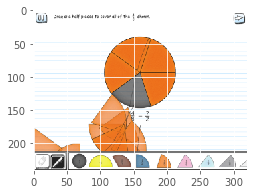

Cluster 5
http://woot_math_cub.s3.amazonaws.com/ss/77653/hxS1eqLik1.1474482947149.png
http://woot_math_cub.s3.amazonaws.com/ss/83178/hxS1eqLik1.1475066450183.png
http://woot_math_cub.s3.amazonaws.com/ss/84969/hxS1eqLik1.1475261400595.png
http://woot_math_cub.s3.amazonaws.com/ss/84969/hxS1eqLik1.1475261423156.png
http://woot_math_cub.s3.amazonaws.com/ss/87230/hxS1eqLik1.1476365055581.png
http://woot_math_cub.s3.amazonaws.com/ss/86811/hxS1eqLik1.1476369243216.png
http://woot_math_cub.s3.amazonaws.com/ss/86791/hxS1eqLik1.1476376047858.png
http://woot_math_cub.s3.amazonaws.com/ss/85604/hxS1eqLik1.1476377012688.png


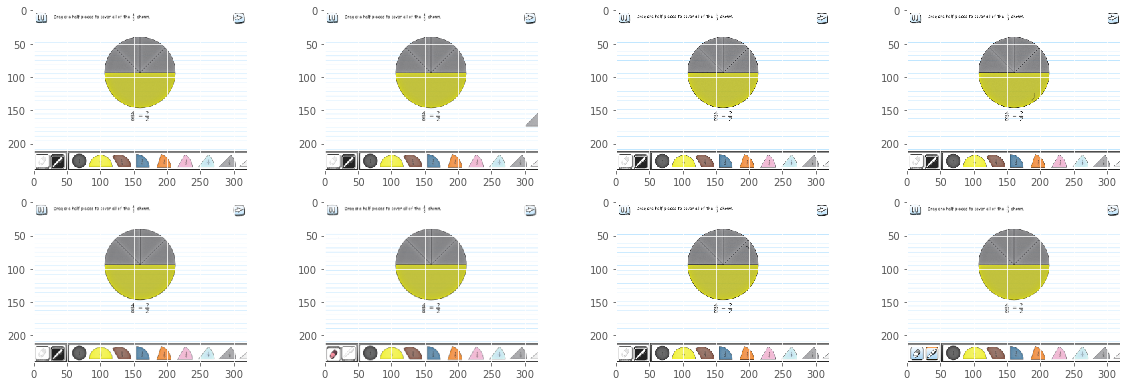

Cluster 6
http://woot_math_cub.s3.amazonaws.com/ss/71257/hxS1eqLik1.1471104859613.png
http://woot_math_cub.s3.amazonaws.com/ss/72827/hxS1eqLik1.1472227058317.png
http://woot_math_cub.s3.amazonaws.com/ss/77102/hxS1eqLik1.1473869665233.png
http://woot_math_cub.s3.amazonaws.com/ss/83921/hxS1eqLik1.1474988079833.png
http://woot_math_cub.s3.amazonaws.com/ss/84945/hxS1eqLik1.1475624164850.png
http://woot_math_cub.s3.amazonaws.com/ss/85120/hxS1eqLik1.1475792782429.png
http://woot_math_cub.s3.amazonaws.com/ss/84849/hxS1eqLik1.1475936580906.png
http://woot_math_cub.s3.amazonaws.com/ss/85369/hxS1eqLik1.1476285473932.png


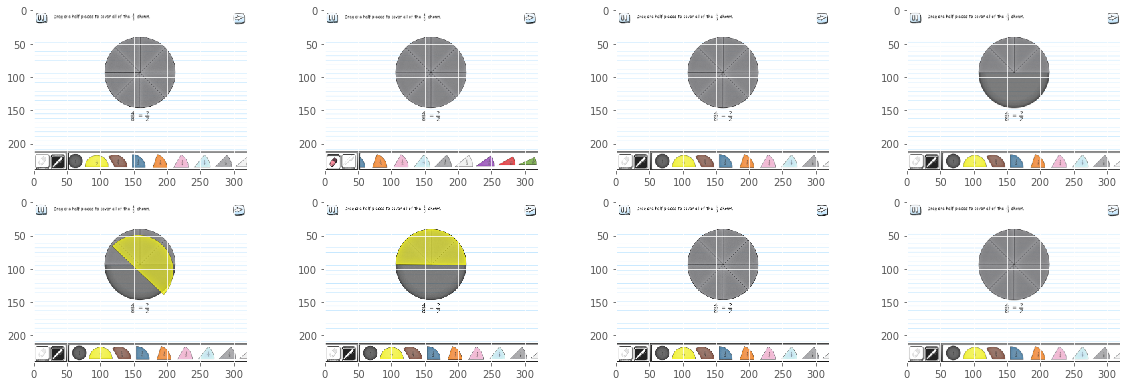

Analysis 8 for qual_id 9wRCzK1G7F.partb.qGGEQyiE_j with 17007 samples
Session 0 txt  The yellow is the whole unit. Which of these pieces is one half of the yellow piece?
Drag the piece to the answer box.
Answer: 1/4
Extracting tf-idf features ...
done in 1.783s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=1, random_state=42, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 0.238s
qual_id 9wRCzK1G7F.partb.qGGEQyiE_j has these clusters
5    1025
9     541
0     411
1     381
4     377
2     367
3     227
8     104
7      51
6      21
Name: cluster, dtype: int64
Cluster 5
http://woot_math_cub.s3.amazonaws.com/ss/74281/qGGEQyiE_j.1471477975701.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/74281/qGGEQyiE_j.1471477975701.png
http://woot_math_cub.s3.amazonaws.com/ss/76116/qGGEQyiE_j.1472664150970.png
http://woot_math_cub.s3.amazonaws

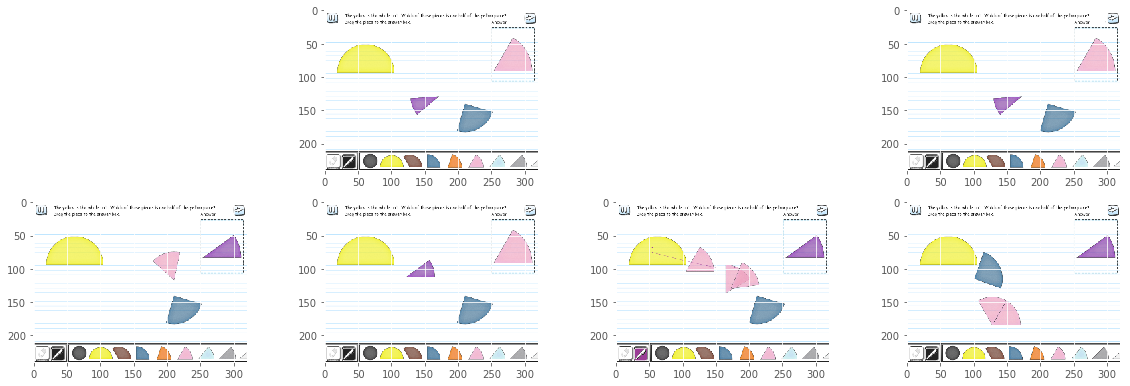

Cluster 9
http://woot_math_cub.s3.amazonaws.com/ss/74240/qGGEQyiE_j.1470180209833.png
http://woot_math_cub.s3.amazonaws.com/ss/74181/qGGEQyiE_j.1470166490992.png
http://woot_math_cub.s3.amazonaws.com/ss/74322/qGGEQyiE_j.1470222906876.png
http://woot_math_cub.s3.amazonaws.com/ss/77562/qGGEQyiE_j.1472751460236.png
http://woot_math_cub.s3.amazonaws.com/ss/76901/qGGEQyiE_j.1473168350279.png
http://woot_math_cub.s3.amazonaws.com/ss/76902/qGGEQyiE_j.1473171402017.png
http://woot_math_cub.s3.amazonaws.com/ss/77142/qGGEQyiE_j.1473256930890.png
http://woot_math_cub.s3.amazonaws.com/ss/77107/qGGEQyiE_j.1473263232265.png


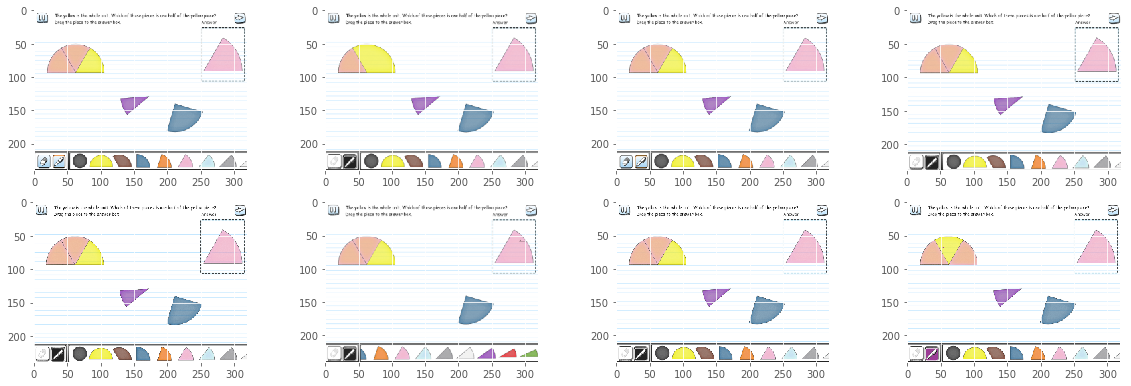

Cluster 0
http://woot_math_cub.s3.amazonaws.com/ss/74238/qGGEQyiE_j.1470180217270.png
http://woot_math_cub.s3.amazonaws.com/ss/74320/qGGEQyiE_j.1470297938028.png
http://woot_math_cub.s3.amazonaws.com/ss/77574/qGGEQyiE_j.1473193642444.png
http://woot_math_cub.s3.amazonaws.com/ss/77684/qGGEQyiE_j.1473352089814.png
http://woot_math_cub.s3.amazonaws.com/ss/76375/qGGEQyiE_j.1473357967818.png
http://woot_math_cub.s3.amazonaws.com/ss/75863/qGGEQyiE_j.1473432400369.png
http://woot_math_cub.s3.amazonaws.com/ss/77229/qGGEQyiE_j.1473437680362.png
http://woot_math_cub.s3.amazonaws.com/ss/76374/qGGEQyiE_j.1473444597081.png


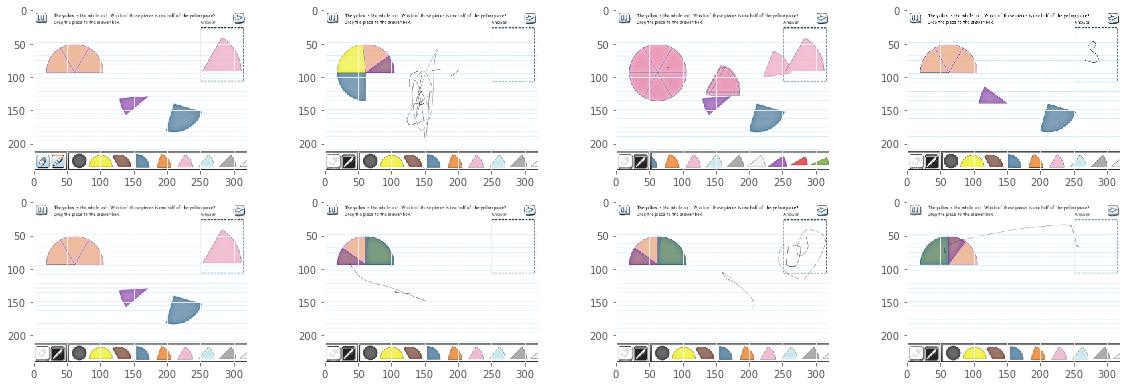

Cluster 1
http://woot_math_cub.s3.amazonaws.com/ss/74230/qGGEQyiE_j.1471216255456.png
http://woot_math_cub.s3.amazonaws.com/ss/77592/qGGEQyiE_j.1472846664263.png
http://woot_math_cub.s3.amazonaws.com/ss/77592/qGGEQyiE_j.1473286487093.png
http://woot_math_cub.s3.amazonaws.com/ss/77676/qGGEQyiE_j.1473352045056.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/77676/qGGEQyiE_j.1473352045056.png
http://woot_math_cub.s3.amazonaws.com/ss/76895/qGGEQyiE_j.1473426093696.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/76895/qGGEQyiE_j.1473426093696.png
http://woot_math_cub.s3.amazonaws.com/ss/74010/qGGEQyiE_j.1473810054496.png
http://woot_math_cub.s3.amazonaws.com/ss/78956/qGGEQyiE_j.1475181256828.png
http://woot_math_cub.s3.amazonaws.com/ss/84498/qGGEQyiE_j.1475250779636.png


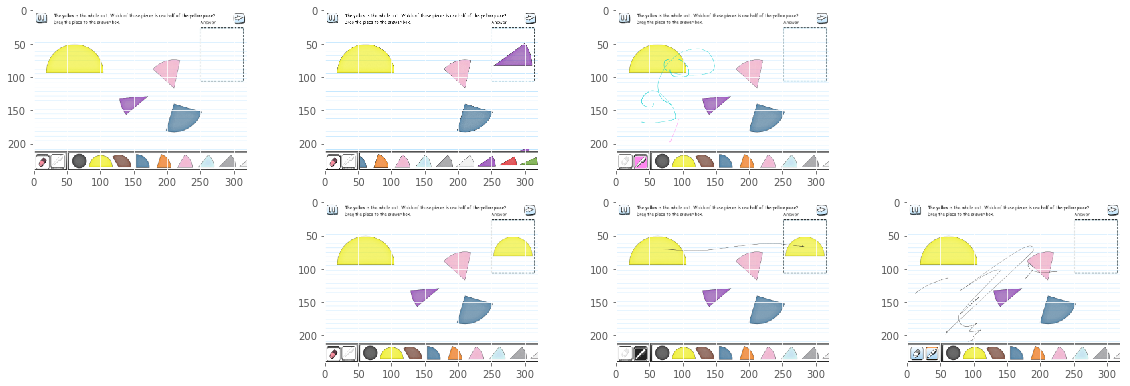

Analysis 9 for qual_id kvig7fcCVc.partb.3y7UMHuR_i with 16876 samples
Session 0 txt  Arrange these fractions from least to greatest.
Drag each fraction into one of the boxes below.
Answer: 2/8,2/6,2/4
Extracting tf-idf features ...
done in 0.921s.
Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=1, random_state=42, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 0.053s
qual_id kvig7fcCVc.partb.3y7UMHuR_i has these clusters
2    1507
0    1080
1     171
9      12
3       3
8       3
7       2
5       2
6       2
4       2
Name: cluster, dtype: int64
Cluster 2
http://woot_math_cub.s3.amazonaws.com/ss/72768/3y7UMHuR_i.1471270613856.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/72768/3y7UMHuR_i.1471270613856.png
http://woot_math_cub.s3.amazonaws.com/ss/74182/3y7UMHuR_i.1471393086814.png
 could not read http://woot_math_cub.s3.amazonaw

Cluster 0
http://woot_math_cub.s3.amazonaws.com/ss/105862/3y7UMHuR_i.1486752896832.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/105862/3y7UMHuR_i.1486752896832.png
http://woot_math_cub.s3.amazonaws.com/ss/105499/3y7UMHuR_i.1486781534406.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/105499/3y7UMHuR_i.1486781534406.png
http://woot_math_cub.s3.amazonaws.com/ss/106924/3y7UMHuR_i.1486993661910.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/106924/3y7UMHuR_i.1486993661910.png
http://woot_math_cub.s3.amazonaws.com/ss/101913/3y7UMHuR_i.1486993934404.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/101913/3y7UMHuR_i.1486993934404.png
http://woot_math_cub.s3.amazonaws.com/ss/101913/3y7UMHuR_i.1486993961504.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/101913/3y7UMHuR_i.1486993961504.png
http://woot_math_cub.s3.amazonaws.com/ss/94210/3y7UMHuR_i.1486993922388.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/94210/3

Cluster 1
http://woot_math_cub.s3.amazonaws.com/ss/74279/3y7UMHuR_i.1471391759807.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/74279/3y7UMHuR_i.1471391759807.png
http://woot_math_cub.s3.amazonaws.com/ss/74228/3y7UMHuR_i.1471414206788.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/74228/3y7UMHuR_i.1471414206788.png
http://woot_math_cub.s3.amazonaws.com/ss/74993/3y7UMHuR_i.1472068768890.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/74993/3y7UMHuR_i.1472068768890.png
http://woot_math_cub.s3.amazonaws.com/ss/74993/3y7UMHuR_i.1472069165160.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/74993/3y7UMHuR_i.1472069165160.png
http://woot_math_cub.s3.amazonaws.com/ss/80924/3y7UMHuR_i.1473184009543.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/80924/3y7UMHuR_i.1473184009543.png
http://woot_math_cub.s3.amazonaws.com/ss/76924/3y7UMHuR_i.1473270543207.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/76924/3y7UMHuR_i.

Cluster 9
http://woot_math_cub.s3.amazonaws.com/ss/74237/3y7UMHuR_i.1473902572051.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/74237/3y7UMHuR_i.1473902572051.png
http://woot_math_cub.s3.amazonaws.com/ss/74237/3y7UMHuR_i.1473902577796.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/74237/3y7UMHuR_i.1473902577796.png
http://woot_math_cub.s3.amazonaws.com/ss/86354/3y7UMHuR_i.1475867193372.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/86354/3y7UMHuR_i.1475867193372.png
http://woot_math_cub.s3.amazonaws.com/ss/86354/3y7UMHuR_i.1475867203255.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/86354/3y7UMHuR_i.1475867203255.png
http://woot_math_cub.s3.amazonaws.com/ss/89657/3y7UMHuR_i.1477420009920.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/89657/3y7UMHuR_i.1477420009920.png
http://woot_math_cub.s3.amazonaws.com/ss/92841/3y7UMHuR_i.1479758272233.png
 could not read http://woot_math_cub.s3.amazonaws.com/ss/92841/3y7UMHuR_i.

In [25]:
for row in range(len(top_ten_qual_id)):
    # print (top_ten_qual_id.iloc[row]['_id']['qual_id'], top_ten_qual_id.iloc[row]['count'])

    this_qid = top_ten_qual_id.iloc[row]['_id']['qual_id']
    count = top_ten_qual_id.iloc[row]['count']
    print ('Analysis {0} for qual_id {1} with {2} samples'.format(row, this_qid, count))


    prob_set = db.anon_student_task_responses.find({'qual_id':this_qid, 'correct': False})
    df3 = make_doc_data_set(prob_set)
    print ('Session 0 txt ', df3.iloc[0]['txt'])   
    df_top_ten.append(df3.copy())
    data_samples = df3['response_doc']
    km = make_k_means(data_samples, clusters=10)
    df3['cluster'] = km.labels_
    print ('qual_id {0} has these clusters'.format(this_qid))
    print (df3['cluster'].value_counts())
      
    
    columns = 4
    num_images = 8
    # Look at top four clusters
    # Print 
    for cluster in (df3['cluster'].value_counts().keys())[:4]:
        plt.clf
        plt.figure(figsize=(20,10))
        print ('Cluster', cluster )

        cluster_data = df3[df3['cluster']==cluster]
        #print (cluster_data[:10])
        images = []
        for idx in range(min(num_images, df3['cluster'].value_counts()[cluster])):
            #    images.append(Image(cluster_data.iloc[idx]['screenshot_url']))
            # create a file-like object from the url
            print (cluster_data.iloc[idx]['screenshot_url'])
            try:
                f = urllib.request.urlopen(cluster_data.iloc[idx]['screenshot_url'])
            except:
                print(' could not read {0}'.format(cluster_data.iloc[idx]['screenshot_url']))
                continue
            # read the image file in a numpy array
            a = plt.imread(f)
            #plt.imshow(a)
            #plt.show()
            #print(image)
            #display(image)
            plt.subplot(min(9, df3['cluster'].value_counts()[cluster]) / columns + 1, columns, idx + 1)
            plt.imshow(a)

        plt.show()
        

    
    